## Ride-hailing Simulation

In [49]:
from collections import OrderedDict
import random
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ride_hailing_dataset_path = r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Ride_hailing_Dataset.csv'
ACTIVE = 'active'
WORKING = 'working'
INACTIVE = 'inactive'
NO_TRIP_ID = -1

## TODO

Objective: minimal code to run RL

1. using status: active, inactive, working to generate driver activities;
2. Gym environment
3. Seperate environment from Matching and Reposition function
4. fitting distribution of demand and supply
5. Python typing check

OD matrix: HA

625*625*12*24: uniform

625*12*24

# CONSTANTS



In [50]:
ride_hailing_dataset_path = r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Ride_hailing_Dataset.csv'
ACTIVE = 'active'
WORKING = 'working'
INACTIVE = 'inactive'
NO_TRIP_ID = -1

# Processing input and output as CSV files

In [51]:
df=pd.read_csv(ride_hailing_dataset_path)
df.head()

,mlsassignedptc,anon_vin,ptcltid,p1start_datetime,p1end_datetime,p1start_long,p1start_lat,p1end_long,p1end_lat,distance_x,...,dropoff_lat,distance_y,fareamount,serviceprovided,cancelreason,Origin,Destination,start_shift,end_shift,request
0,850,1.0,bea1f00dc3093ab2a42745ed4b0c9d754a0c8d7c391103...,2020-01-02 13:30,2020-01-02 13:41,-79.3625,43.7737,-79.4103,43.7585,4.2,...,NaN,NaN,NaN,NaN,NaN,467.0,441.0,1,1,0
1,850,1.0,7bb23c3714b9a1f82c0547a22f483f6f0f1a24e22e552f...,2020-01-02 14:01,2020-01-02 14:11,-79.4182,43.7893,-79.4171,43.7821,0.8,...,NaN,NaN,NaN,NaN,NaN,445.0,444.0,1,1,0
2,850,1.0,8ec058ee50a1048817824b48fd74f977ea2c65fb8fd2f0...,2020-01-02 14:17,2020-01-02 14:33,-79.4171,43.7821,-79.4664,43.7690,4.2,...,NaN,NaN,NaN,NaN,NaN,444.0,429.0,1,1,0
3,850,1.0,e6e485b94a3f1fdb6cad578f2424d0b7b167a8d9960509...,2020-01-02 14:45,2020-01-02 15:02,-79.4391,43.7752,-79.4898,43.7453,5.3,...,NaN,NaN,NaN,NaN,NaN,435.0,412.0,1,1,0
4,850,1.0,60ddd7d8de38d7ecf63e1c2c39efda2ae44c422c789a1a...,2020-01-02 15:14,2020-01-02 15:18,-79.4797,43.7533,-79.4690,43.7536,0.9,...,NaN,NaN,NaN,NaN,NaN,418.0,394.0,1,1,0


# Add Demand

In [52]:
df = df[df['request'] == 1]

# Convert the datetime columns to pandas datetime format
df["passengerpickupdatetime"] = pd.to_datetime(df["passengerpickupdatetime"])
df["passengerdropoffdatetime"] = pd.to_datetime(df["passengerdropoffdatetime"])

# Calculate the duration in minutes and create a new column
df["duration"] = (df["passengerdropoffdatetime"] - df["passengerpickupdatetime"]).dt.total_seconds() / 60

# List of columns you want to delete
columns_to_delete = [
    "mlsassignedptc", "anon_vin", "ptcltid", "p1start_datetime",
    "p1end_datetime", "p1start_long", "p1start_lat", "p1end_long",
    "p1end_lat", "distance_x", "event_type", "start_datetime",
    "end_datetime", "trippassengerid", "driverwaittime",
    "tripstatusid", "accessible", "driveracceptancedatetime",
    "driverarrivaldatetime", "passengerpickupdatetime",
    "passengerdropoffdatetime", "pickup_long", "pickup_lat",
    "dropoff_long", "dropoff_lat", "serviceprovided", "cancelreason",
    "start_shift", "end_shift", "request"
]

# Dropping the columns from the DataFrame
demand_df = df.drop(columns=columns_to_delete, errors='ignore')

demand_df.to_csv(r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Demand.csv', index = False)


# Add Driver

In [53]:
driver_df = df[df['start_shift'] == 1]



# List of columns you want to delete
columns_to_delete = [
    "mlsassignedptc",  "ptcltid", "p1start_datetime",
    "p1end_datetime", "p1start_long", "p1start_lat", "p1end_long",
    "p1end_lat", "distance_x", "event_type",
    "end_datetime", "trippassengerid", "driverwaittime", "Destination"
    "tripstatusid", "accessible", "driveracceptancedatetime",
    "driverarrivaldatetime", "passengerpickupdatetime",
    "passengerdropoffdatetime", "pickup_long", "pickup_lat",
    "dropoff_long", "dropoff_lat", "serviceprovided", "cancelreason",
    "start_shift", "end_shift", "request", "ptctripid",	"tripstatusid",	"requestdatetime",	"distance_y",	"fareamount", "Destination",


]

# Dropping the columns from the DataFrame
driver_df= driver_df.drop(columns=columns_to_delete, errors='ignore')


drive_df_save_path = r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Driver.csv'
driver_df.to_csv(drive_df_save_path, index = False)

# Different Supply Level

In [54]:
## Different Supply Level
def filter_drivers_save_csv(input_df, percentage_to_keep, output_file_path, random_seed=None):
    """
    Filters a given percentage of drivers from the input DataFrame and saves the filtered DataFrame to a CSV file.

    Parameters:
    - input_df (pd.DataFrame): Input DataFrame containing driver data.
    - percentage_to_keep (float): Percentage of drivers to keep (between 0 and 1).
    - output_file_path (str): Path to save the output CSV file.

    Returns:
    - None
    """
    # Ensure the input percentage is within the expected range
    if not (0 < percentage_to_keep <= 1):
        raise ValueError("Percentage to keep must be between 0 and 1.")

    # Shuffle the DataFrame to randomize the selection
    shuffled_df = input_df.sample(frac=1).reset_index(drop=True)

    # Get unique drivers
    unique_drivers = shuffled_df['anon_vin'].unique()

    # Calculate the number of drivers to keep
    drivers_to_keep_count = int(len(unique_drivers) * percentage_to_keep)

    # Select a subset of drivers to keep
    drivers_to_keep = unique_drivers[:drivers_to_keep_count]

    # Filter the DataFrame to only include selected drivers
    filtered_df = shuffled_df[shuffled_df['anon_vin'].isin(drivers_to_keep)]

    # Save the filtered DataFrame to a CSV file
    filtered_df.to_csv(output_file_path, index=False)

    print(f"Filtered data saved to {output_file_path}. Kept {drivers_to_keep_count} drivers out of {len(unique_drivers)} total drivers.")

In [55]:
input_df=pd.read_csv(r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Driver.csv')
output_file_path=r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Scenario_different_supply_level\0.1Supply.csv'
filter_drivers_save_csv(input_df, 0.1, output_file_path, random_seed=155)

Filtered data saved to D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Scenario_different_supply_level\0.1Supply.csv. Kept 782 drivers out of 7820 total drivers.


## add survival function

In [24]:
from datetime import datetime

# Assuming df_shifts is already defined, we first ensure start_datetime and end_datetime are datetime objects
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df['end_datetime'] = pd.to_datetime(df['end_datetime'])

# We'll define a new function to calculate the duration of each shift
def calculate_correct_shift_durations(df):
    # Sort by anon_vin and start_datetime to ensure correct chronological order
    df = df.sort_values(by=['anon_vin', 'start_datetime'])

    # List to hold the result
    shifts = []

    # Temporary variables to hold the start and end of the current shift
    current_shift_start = None
    current_shift_end = None
    current_vin = None

    # Iterate through the DataFrame
    for index, row in df.iterrows():
        # If we're starting a new shift or continuing an existing shift
        if current_vin != row['anon_vin'] or row['start_shift'] == 1:
            # If there was a previous shift, save it
            if current_shift_start is not None:
                shifts.append({
                    'anon_vin': current_vin,
                    'shift_start': current_shift_start,
                    'shift_end': current_shift_end,
                    'duration_minutes': (current_shift_end - current_shift_start).total_seconds() / 60
                })

            # Start a new shift
            current_vin = row['anon_vin']
            current_shift_start = row['start_datetime']
            current_shift_end = row['end_datetime']
        else:
            # Continue the current shift
            current_shift_end = row['end_datetime']

    # Don't forget to add the last shift
    if current_shift_start is not None:
        shifts.append({
            'anon_vin': current_vin,
            'shift_start': current_shift_start,
            'shift_end': current_shift_end,
            'duration_minutes': (current_shift_end - current_shift_start).total_seconds() / 60
        })

    return pd.DataFrame(shifts)

# Calculate the correct shift durations
correct_shift_durations = calculate_correct_shift_durations(df)
correct_shift_durations.to_csv(r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Shift.csv', index = False)


NameError: name 'df' is not defined

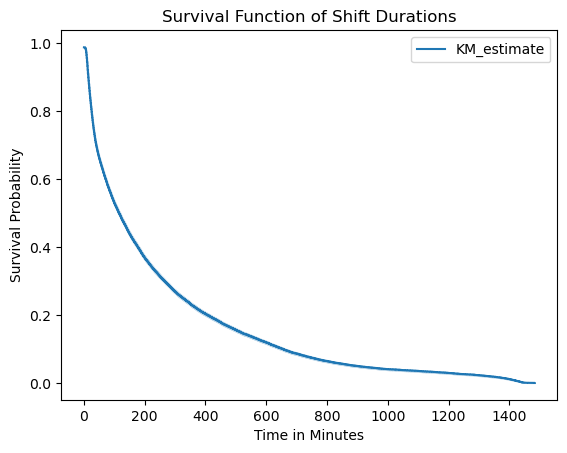

In [25]:
import numpy as np
from lifelines import KaplanMeierFitter
import pandas as pd
import matplotlib.pyplot as plt


# Assuming df_shifts is your DataFrame with the shift data

correct_shift_durations=pd.read_csv(r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Shift.csv')


# Create an event_observed array of ones, with the same length as the duration_minutes column
event_observed = np.ones_like(correct_shift_durations["duration_minutes"])

kmf = KaplanMeierFitter()
kmf.fit(durations=correct_shift_durations["duration_minutes"], event_observed=event_observed)

kmf.plot_survival_function()
plt.title('Survival Function of Shift Durations')
plt.xlabel('Time in Minutes')
plt.ylabel('Survival Probability')
plt.show()



In [26]:
kmf.predict(1)

0.9882366464863219

## add interzonal time

## define class Driver, TripRequest, Simulation

In [27]:
from collections import OrderedDict
import random
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ride_hailing_dataset_path = r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Ride_hailing_Dataset.csv'
ACTIVE = 'active'
WORKING = 'working'
INACTIVE = 'inactive'
NO_TRIP_ID = -1

## Fit driver survival model

In [28]:

class Driver:
    def __init__(self, name, current_location, start_time):
        self.name = name
        self.current_location = current_location
        # Q: Can we What is the diff between is_available = False and an 'inactive' state?
        # A: available means whether a driver is available for accepting new trip;
        # not available == inactive or working state
        # available == active state
        # hence is_available == (state == 'active')
        self.is_available = True  # Initially, all drivers are available.
        self.start_time = start_time
        self.activity_log = OrderedDict() # {timestep1: [state, id, start_location, end_location]} OrderedDict[Int: List]
        self.state = 'active'  # 'active', 'working', 'inactive'
        self.last_survival_probability = 1  # Initial survival probability is 1 (100%)


    def log_activity(self, time_step, activity):
        self.activity_log[time_step] = activity

    def update_availability(self, current_time):
        # Check if the driver's start time has passed and update availability
        if current_time >= self.start_time and self.state == 'active':
            self.is_available = True
        else:
            self.is_available = False


    def assign_to_trip(self, time_step, trip_request):
        self.is_available = False
        self.state = 'working'
        activity = [self.state, trip_request.ID, trip_request.start_location, trip_request.end_location]
        self.log_activity(time_step, activity)

    def complete_trip(self, time_step, trip_request):
        self.current_location = trip_request.end_location
        self.is_available = True
        self.state = 'active'
        activity = [self.state, trip_request.ID, trip_request.start_location, trip_request.end_location]
        self.log_activity(time_step, activity)

    def leave_platform(self, time_step):
        self.is_available = False
        self.state = 'inactive'
        activity = [self.state, NO_TRIP_ID, self.current_location, self.current_location]
        self.log_activity(time_step, activity)
        
    def leave_platform_due_to_duration(self, current_time):
        WORKING_HOUR_PER_DRIVER = 3600
        if current_time - self.start_time >= WORKING_HOUR_PER_DRIVER:
            self.leave_platform(current_time)


    def return_to_the_platform(self, current_time):
        self.current_location = trip_request.end_location
        self.is_available = True
        self.state = 'active'
        activity = [self.state, trip_request.ID, trip_request.start_location, trip_request.end_location]
        self.log_activity(time_step, activity)

    # def leave_platform_due_to_duration(self, kmf, current_time):
    #     # Calculate total time on the platform
    #     total_duration = current_time - self.start_time

    #     # Calculate the new survival probability
    #     new_survival_probability = kmf.predict(total_duration)

    #     # Calculate the ratio or difference as the conditional probability
    #     if self.last_survival_probability > 0:  # Prevent division by zero
    #         conditional_probability = new_survival_probability / self.last_survival_probability
    #     else:
    #         conditional_probability = 0

    #     # Update the last recorded survival probability to the new survival probability
    #     self.last_survival_probability = new_survival_probability

    #     # Generate a random number between 0 and 1
    #     random_chance = random.random()

    #     # If the random chance is greater than the survival probability, the driver decides to leave
    #     if random_chance > conditional_probability:
    #         self.leave_platform(current_time)
    #         print(f"{self.name} has left the platform due to survival probability analysis.")



class TripRequest:
    def __init__(self, ID, request_time, duration, start_location, end_location):
        self.ID = ID
        self.request_time = request_time
        self.duration = duration
        self.start_location = start_location
        self.end_location = end_location
        self.assigned_driver = None  # is an instance of Driver class
        self.is_completed = False
        self.pickup_time = None  # Will be set when assigned
        self.assigned_time = None  # Will be set when completed

class Simulation:
    def __init__(self):
        # TODO: use dict {driver_id: driver_instance} to record drivers.
        self.active_drivers = OrderedDict()
        self.working_drivers = OrderedDict()
        self.inactive_drivers = OrderedDict()
        self.current_time = 0
        self.requesting_trips = []
        self.serviced_trips = []
        self.travel_time_lookup = {}
       # self.add_travel_time_lookup_from_csv()

    # # TODO: initialize this lookup in __init__
    # def add_travel_time_lookup_from_csv(self, csv_file):
    #     # Read the CSV file into a DataFrame
    #     data_dict = {(0,0): 2, (0,1): 2, (1,0): 2, (1,1): 2, (2,1): 2, (1,2): 2}
    #     data_list = [{'Origin': key[0], 'Destination': key[1], 'Data': value} for key, value in data_dict.items()]
    #     # Create the DataFrame
    #     df = pd.DataFrame(data_list)
    #     # Iterate through the DataFrame rows
    #     for index, row in df.iterrows():
    #         # Update the travel time lookup dictionary
    #         # The key is a tuple of (Origin, Destination)
    #         # The value is the travel time 'Data'
    #         self.travel_time_lookup[(row['Origin'], row['Destination'])] = int(row['Data'])

    def add_travel_time_lookup_from_csv(self, csv_file):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_file)
        
        # Iterate through the DataFrame rows
        for index, row in df.iterrows():
            # Update the travel time lookup dictionary
            # The key is a tuple of (Origin, Destination)
            # The value is the travel time 'Data'
            self.travel_time_lookup[(row['Origin'], row['Destination'])] = int(row['Data'])



    # TODO: replace add driver with driver generation function.
    # Currently, add_driver is only executed once when Simulation is instantiated. Thus, there is no need to
    # tell the driver state, as for a newly instantiated driver, its state is always active.
    # Is there any future use of this function?
    def add_driver(self, driver):
        assert driver.state == 'active'
        self.active_drivers[driver.name] = driver
        activity = [driver.state, NO_TRIP_ID, driver.current_location, driver.current_location]
        driver.log_activity(driver.start_time, activity)

    # TODO: remove driver as per driver survival model
    def remove_driver(self, driver_name, time_step):
        driver = self.active_drivers[driver_name]
        driver.leave_platform(time_step)
        self.active_drivers.pop(driver_name)
        self.inactive_drivers[driver_name] = driver


    # TODO: add trip request as per trip generation function
    def add_trip_request(self, trip_request):
        self.requesting_trips.append(trip_request)

    # TODO: seperate driver-trip matching policy from environment class
    def assign_driver_to_trip(self, strategy='greedy'):
        # Method to select the assignment strategy
        if strategy == 'greedy':
            self.assign_driver_by_greedy()
        elif strategy == 'availability':
            self.assign_driver_by_availability()
        else:
            print("Invalid strategy specified.")

    # TODO: seperate driver-trip matching policy from environment class
    def assign_driver_by_greedy(self):
        # assign driver by minimal travel time from driver location to passenger pickup location
        for trip_request in self.requesting_trips:
            if trip_request.request_time <= self.current_time and not trip_request.assigned_driver:
                best_driver = None
                min_travel_time = float('inf')
                # list() is shallow copy itself, no need to have another deepcopy
                for driver in list(self.active_drivers.values()):
                    # Check if the driver is available before considering them for assignment
                    if driver.is_available:
                        pair = (driver.current_location, trip_request.start_location)
                        travel_time_to_pickup = self.travel_time_lookup.get(pair)
                        travel_time_to_pickup = 0 if travel_time_to_pickup is None else travel_time_to_pickup
                       # assert travel_time_to_pickup is not None, f"There is no inter-zonal distance in lookup for driver current location and trip request location {(driver.current_location, trip_request.start_location)}"
                        if travel_time_to_pickup < min_travel_time:
                            best_driver = driver
                            min_travel_time = travel_time_to_pickup

                if best_driver:
                    # Assign the best driver to the trip
                    trip_request.assigned_time = self.current_time
                    trip_request.pickup_time = self.current_time + min_travel_time
                    trip_request.assigned_driver = best_driver

                    best_driver.assign_to_trip(trip_request.pickup_time, trip_request)
                    # Since the driver is now working on a trip, they are no longer available
                    best_driver.is_available = False

                    # Move the driver from active to working drivers
                    self.active_drivers.pop(best_driver.name)
                    self.working_drivers[best_driver.name] = best_driver

                 #   print(f"Assigned {best_driver.name} to trip request {trip_request.ID} from {trip_request.start_location} to {trip_request.end_location}.")


    # TODO: rename function: set_offline_driver_by_survival_model
    def check_active_drivers_duration(self):
        # list() is deepcopy itself, no need to have another deepcopy
        for driver in list(self.active_drivers.values()):  # Use a copy for safe iteration
            driver.leave_platform_due_to_duration( self.current_time)
            if driver.state == 'inactive':
                self.active_drivers.pop(driver.name)
                self.inactive_drivers[driver.name] = driver

    # TODO: seperate driver-trip matching policy from environment class
    def assign_driver_by_availability(self):
        for trip_request in self.requesting_trips:
            if trip_request.request_time <= self.current_time and not trip_request.assigned_driver and self.active_drivers:
                driver_to_assign = self.active_drivers.pop(0)
                travel_time_to_pickup = self.travel_time_lookup.get((driver_to_assign.current_location, trip_request.start_location), 0)
                trip_request.assigned_time=self.current_time
                trip_request.pickup_time = self.current_time + travel_time_to_pickup
                trip_request.assigned_driver = driver_to_assign
                driver_to_assign.assign_to_trip(trip_request.pickup_time, trip_request)
                self.working_drivers.append(driver_to_assign)
             #   print(f"Assigned {driver_to_assign.name} to trip request {trip_request.ID} from {trip_request.start_location} to {trip_request.end_location}.")


    def update_all_drivers_states(self):
        for trip_request in self.requesting_trips[:]:
          #  print("trip", trip_request.ID, "driver", trip_request.assigned_driver)
            if trip_request.assigned_driver and self.current_time >= (trip_request.pickup_time + trip_request.duration):
             #   print("current_time", self.current_time)
                trip_request.is_completed = True
                trip_request.assigned_driver.complete_trip(self.current_time, trip_request)
                self.serviced_trips.append(trip_request)
                self.requesting_trips.remove(trip_request)
                if self.working_drivers.get(trip_request.assigned_driver.name):
                    self.working_drivers.pop(trip_request.assigned_driver.name)
                    self.active_drivers[trip_request.assigned_driver.name] = trip_request.assigned_driver
              #  print(f"{trip_request.assigned_driver.name} completed trip {trip_request.ID} to {trip_request.end_location}.")




    def run(self, steps):
        for _ in range(steps):
            # Update each driver's availability based on the current simulation time
            #print("time", self.current_time)
            self.update_all_drivers_states()

            # TODO: is self.update_all_drivers_states() covering driver.update_availability() ?
            # Is updating driver instance reflected on driver on self.active_drivers? Yes.
            # list() is shallow copy itself
            for driver in list(self.active_drivers.values()):
                #print(driver.name, driver.is_available)
                driver.update_availability(self.current_time)

            self.check_active_drivers_duration()  # Check and potentially remove drivers first

        #    print("active_drivers before assign", self.active_drivers.keys())
        #    print("working_drivers before assign", self.working_drivers.keys())
         #   print("inactive_drivers before assign", self.inactive_drivers.keys())

            self.assign_driver_to_trip(strategy='greedy')
          #  print("active_drivers after assign", self.active_drivers.keys())

          
           # print("working_drivers after assign", self.working_drivers.keys())
          #  print("inactive_drivers after assign", self.inactive_drivers.keys())

            self.current_time += 1

    def reset(self):
        pass

    def step(self, action):
        pass




In [29]:
# Assuming df_shifts is your DataFrame with the shift data
# correct_shift_durations=pd.read_csv(r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Shift.csv')

# # Create an event_observed array of ones, with the same length as the duration_minutes column
# event_observed = np.ones_like(correct_shift_durations["duration_minutes"])

# kmf = KaplanMeierFitter()
# kmf.fit(durations=correct_shift_durations["duration_minutes"], event_observed=event_observed)

## instantiate Simulation

In [30]:
simulation_instance = Simulation()
simulation_instance.add_travel_time_lookup_from_csv(r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\aivtt.csv')

## Reading the demand CSV

In [31]:
def read_trip_requests(csv_file, start_datetime):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    df.dropna(subset=['requestdatetime','ptctripid','duration','Origin','Destination'], inplace=True)

    # Convert 'start_datetime' column to datetime
    df['requestdatetime'] = pd.to_datetime(df['requestdatetime'])

    # Define the simulation start time as the first 'start_datetime' or a predefined time
    simulation_start_time = pd.to_datetime(start_datetime)

    # Calculate time steps as the difference from the simulation start time in minutes
    df['requestdatetime'] = ((df['requestdatetime'] - simulation_start_time).dt.total_seconds() / 60).astype(int)

    # Create a list to hold TripRequest objects
    trip_requests = []

    # Iterate through the DataFrame rows and create TripRequest objects
    for index, row in df.iterrows():
        trip_request = TripRequest(
            ID=row['ptctripid'],
            request_time=row['requestdatetime'],  # Use the calculated start_time_step
            duration=int(row['duration']),
            start_location=int(row['Origin']),
            end_location=int(row['Destination'])
        )
        trip_requests.append(trip_request)

    return trip_requests

# Assuming you have the Simulation class defined as before
# Initialize the simulation
simulation_start_datetime = "2020-01-02 0:00"
# Read trip requests from the CSV file
trip_requests = read_trip_requests(r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Demand.csv',simulation_start_datetime)
# Add each trip request to the simulation
for trip_request in trip_requests:
    simulation_instance.add_trip_request(trip_request)

## Reading the Driver CSV

In [32]:
def read_drivers(csv_file, simulation_start_datetime):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Ensure no missing values in critical columns
    df.dropna(subset=['start_datetime', 'anon_vin', 'Origin'], inplace=True)

    # Convert 'start_datetime' column to datetime
    df['start_datetime'] = pd.to_datetime(df['start_datetime'])

    # Define the simulation start time as a predefined time
    simulation_start_time = pd.to_datetime(simulation_start_datetime)

    # Calculate start time in minutes from the simulation start time
    df['start_time'] = ((df['start_datetime'] - simulation_start_time).dt.total_seconds() / 60).astype(int)

    # Create a list to hold Driver objects
    drivers = []

    # Iterate through the DataFrame rows and create Driver objects
    for index, row in df.iterrows():
        driver = Driver(
            name=row['anon_vin'],
            start_time=row['start_time'],  # Use the calculated start time in minutes
            current_location=int(row['Origin'])
        )



        drivers.append(driver)

    return drivers

# Assuming you have a simulation instance created somewhere as 'simulation_instance'
simulation_start_datetime = "2020-01-02 0:00"
# drivers = read_drivers(r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Driver.csv', simulation_start_datetime)

drivers = read_drivers(r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\Driver.csv', simulation_start_datetime)

# Add each driver to the simulation
for driver in drivers:
    simulation_instance.add_driver(driver)

In [33]:
simulation_instance.run(2000)

## P1 and Trip Record

In [34]:
import pandas as pd
from datetime import datetime, timedelta

def format_time_step(time_step):
    base_time = datetime(2020, 1, 2, 0, 0)  # Starting point of the simulation
    delta = timedelta(minutes=time_step)  # Assuming each time_step represents minutes directly
    return (base_time + delta).strftime("%Y-%m-%d %H:%M:%S")

all_drivers = {**simulation_instance.active_drivers, **simulation_instance.working_drivers, **simulation_instance.inactive_drivers}

p1_periods_data = []
for driver_name, driver in all_drivers.items():
    last_active_time_step = None  # To track when the last active period started
    for time_step, activity in driver.activity_log.items():
        state = activity[0]
        if state == 'active' and last_active_time_step is None:
            # Mark the beginning of a potential idle period
            last_active_time_step = time_step
        elif state == 'working' and last_active_time_step is not None:
            # Found a working period after being active, log the idle period
            p1_periods_data.append({
                "anon_vin": driver.name,
                "start_zone": last_location,  # Using the last known location before going to 'working' state
                "end_zone": activity[2],  # Start location of the trip
                "distance": "N/A",
                "event_type": "P1 Event",
                "idle_start_datetime": format_time_step(last_active_time_step),
                "idle_end_datetime": format_time_step(time_step)
            })
            last_active_time_step = None  # Reset after logging the idle period
        last_location = activity[3]  # Always update the last known location

df_p1_periods = pd.DataFrame(p1_periods_data)
df_p1_periods.head()

df_p1_periods.to_csv(r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\result\P2.csv', index = False)

In [35]:
import pandas as pd
from datetime import datetime, timedelta

# Assuming the format_time_step function definition as before
def format_time_step(time_step):
    base_time = datetime(2020, 1, 2, 0, 0)  # Adjust according to your simulation's start date and time
    delta = timedelta(minutes=time_step)  # Ensure time_step matches the intended unit (e.g., minutes)
    return (base_time + delta).strftime("%Y-%m-%d %H:%M:%S")

# Combine requesting and serviced trips
all_trips = simulation_instance.requesting_trips + simulation_instance.serviced_trips

trip_data = []
for trip_request in all_trips:
    if trip_request.is_completed:
        if trip_request.assigned_driver:
            trip_data.append({
                "request_ID": trip_request.ID,
                "anon_vin": trip_request.assigned_driver.name,
                "start_zone": trip_request.start_location,
                "end_zone": trip_request.end_location,
                "distance": "N/A",  # Consider implementing distance calculation if applicable
                "event_type": "Complete trip",
                "request_datetime": format_time_step(trip_request.request_time),
                "driver_acceptance_datetime": format_time_step(trip_request.assigned_time),
                "passenger_pickup_datetime": format_time_step(trip_request.pickup_time),
                "passenger_drop_datetime": format_time_step(trip_request.pickup_time + trip_request.duration)
            })

# Convert to DataFrame
df_trip_data = pd.DataFrame(trip_data)

# Optionally, display the first few rows to check the data
df_trip_data.head()


df_trip_data.to_csv(r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\result\trip2.csv', index = False)

## Criteria Output

In [36]:
import pandas as pd

def calculate_average_waiting_time(csv_file):
    # Load the data from CSV
    df = pd.read_csv(csv_file)

    # Ensure datetime columns are in the correct format
    df["request_datetime"] = pd.to_datetime(df["request_datetime"])
    df["passenger_pickup_datetime"] = pd.to_datetime(df["passenger_pickup_datetime"])

    # Calculate waiting time in minutes
    df["waiting_time"] = (df["passenger_pickup_datetime"] - df["request_datetime"]).dt.total_seconds() / 60

    # Calculate average waiting time
    average_waiting_time = df["waiting_time"].mean()

    return average_waiting_time

# Example usage
trip_data = r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\result\trip2.csv'
average_waiting_time = calculate_average_waiting_time(trip_data)
print(f"The average waiting time for each trip is {average_waiting_time} minutes.")


The average waiting time for each trip is 15.785937868403295 minutes.


In [37]:
import pandas as pd

def calculate_mean_idle_time_all_drivers(csv_file):
    # Load the data from CSV
    df = pd.read_csv(csv_file)

    # Convert datetime columns to the correct format
    df["idle_start_datetime"] = pd.to_datetime(df["idle_start_datetime"])
    df["idle_end_datetime"] = pd.to_datetime(df["idle_end_datetime"])

    # Calculate idle time in minutes for each event
    df["idle_time_minutes"] = (df["idle_end_datetime"] - df["idle_start_datetime"]).dt.total_seconds() / 60

    # Calculate mean idle time across all drivers
    mean_idle_time_all_drivers = df["idle_time_minutes"].mean()

    return mean_idle_time_all_drivers

# Example usage
csv_file_path = r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\result\P1.csv'
mean_idle_time_all_drivers = calculate_mean_idle_time_all_drivers(csv_file_path)
print(f"Mean Idle Time for All Drivers: {mean_idle_time_all_drivers} minutes")


Mean Idle Time for All Drivers: 11.174602209384819 minutes


In [38]:
def calculate_utilization_rate(trips_csv_file, idle_csv_file):
    # Load the trips data
    trips_df = pd.read_csv(trips_csv_file)
    trips_df["passenger_pickup_datetime"] = pd.to_datetime(trips_df["passenger_pickup_datetime"])
    trips_df["passenger_drop_datetime"] = pd.to_datetime(trips_df["passenger_drop_datetime"])
    trips_df["trip_time"] = (trips_df["passenger_drop_datetime"] - trips_df["passenger_pickup_datetime"]).dt.total_seconds() / 60

    # Load the idle data
    idle_df = pd.read_csv(idle_csv_file)
    idle_df["idle_start_datetime"] = pd.to_datetime(idle_df["idle_start_datetime"])
    idle_df["idle_end_datetime"] = pd.to_datetime(idle_df["idle_end_datetime"])
    idle_df["idle_time"] = (idle_df["idle_end_datetime"] - idle_df["idle_start_datetime"]).dt.total_seconds() / 60

    # Calculate total trip time and total idle time
    total_trip_time = trips_df["trip_time"].sum()
    total_idle_time = idle_df["idle_time"].sum()

    # Calculate utilization rate
    utilization_rate = total_trip_time / (total_trip_time + total_idle_time)

    return utilization_rate

# Example usage
trips_csv_file_path = r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\result\trip2.csv'
idle_csv_file_path = r'D:\OneDrive - University of Toronto\City Simulation\2024.02.04 City of Toronto Simulation Platform\Dataset\New folder\result\P2.csv'
utilization_rate = calculate_utilization_rate(trips_csv_file_path, idle_csv_file_path)
print(f"Utilization Rate: {utilization_rate}")


Utilization Rate: 0.48022861199858


## Fine-tune the model